# Exercise 5 - DSAC

## Import packages

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import torch

from skimage.draw import line, line_aa, circle, set_color, circle_perimeter_aa
from skimage.io import imsave
from skimage.util import random_noise

from vll.utils.train_dsac import default_params, train_line_dsac, train_circle_dsac
from vll.visualize.dsac import visualize_circle_dsac

from vll.data.circle_dataset import ICircleDataset
from vll.utils.circle_loss import ICircleLoss
from vll.utils.circle_dsac import ICircleDSAC

## Task 1
(2 points)

Run the line fitting example (~100 iterations). Plot the training losses.

In [5]:
def running_mean(X, Y, window):
    '''
    Compute the running mean (similar to exercise 1), already implemented

    X -- values for X (for cropping)
    Y -- values for Y (for filtering)
    window -- window size for mean filter
    '''
    offset = window // 2
    x = X[offset:-offset]
    y = np.convolve(Y, np.repeat(1.0, window) / window, mode='valid')
    return x, y


def plot_loss(log_file_path):
    '''
    Read the log file and plot the losses.
    
    log_file_path -- the log file containing the train loss
    '''
    # TODO: use the csv module to load the loss curves from a csv-file
    with open(log_file_path, newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')

        # TODO: extract first, third and fourth column from csv-data
        x, dsac, dp = [], [], []
        for i, row in enumerate(csv_reader):
            x.append(float(row[0]))
            dsac.append(float(row[2]))
            dp.append(float(row[3]))

    # TODO: plot loss for DSAC winning hypothesis (column 3)
    plt.plot(x, dsac, label='DSAC')
    
    # TODO: plot loss for direct prediction (column 4)
    plt.plot(x, dp, label='dp')
    
    # show plot
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

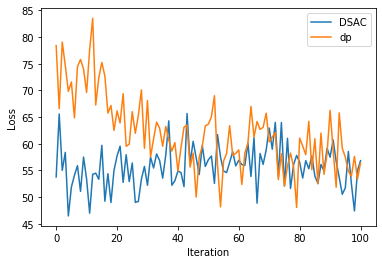

In [6]:
# train already implemented line fitting example and plot loss
#params = default_params('line')
#train_line_dsac(params)
plot_loss('./models/log_dsac_line.txt')

## Task 2
(1 point)

Implement the generation of synthetic circle images.

{'receptivefield': 65, 'capacity': 4, 'hypotheses': 64, 'inlierthreshold': 0.05, 'inlieralpha': 0.5, 'inlierbeta': 100.0, 'learningrate': 0.001, 'lrstep': 2500, 'lrstepoffset': 30000, 'batchsize': 32, 'trainiterations': 100, 'imagesize': 64, 'storeinterval': 10, 'valsize': 9, 'valthresh': 5, 'use_gpu': False, 'id': 'circle'}


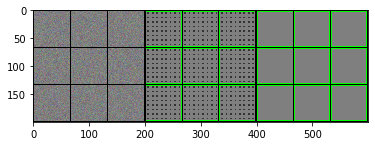

In [7]:
# load hyperparameter dictionary
params = default_params('circle')
print(params)

# initialize dataset
dataset = ICircleDataset(params['imagesize'], params['imagesize'])

# plot empty visualization
visualize_circle_dsac(params, dataset)

In [8]:
maxSlope = 10 # restrict the maximum slope of generated lines for stability
minLength = 20 # restrict the minimum length of line segments

class CircleDataset(ICircleDataset):
    def samples(self, n):
        '''
        Create new input images of random line segments and distractors along with ground truth parameters.

        n -- number of images to create
        '''
        data = np.zeros((n, self.imgH, self.imgW, 3), dtype=np.float32)
        data.fill(self.bg_clr)
        labels = np.ndarray((n, 3), dtype=np.float32)
        
        for i in range (0, n): # for each image
            # TODO:

            # You are given the tensors data and labels which you have to fill. 
            # Within this for loop, you work with data[i] and labels[i].

            # data[i]:
            #    draw a random number of random line segments in random colors, e.g. 2 to 5 lines
            #    draw one circle with a random center position, 
            #    a random radius in the range of 0.1 * self.imgW to 0.5 * self.imgW
            #    and a random color
            #    see the line fitting code for reference

            # labels[i]:
            #    should contain x and y of the circle center, and radius of the circle in this order
            #    the labels should be in normalized image coordinates, i.e. divided by the image size

            # -- STUDENT BEGIN --------------------------------------------------------
            
            n_lines = np.random.randint(2, 6)
            for j in range(n_lines):
                row_descr = np.random.randint(0, self.imgH, 2)
                col_descr = np.random.randint(0, self.imgW, 2)
                rr, cc, val = line_aa(row_descr[0], col_descr[0], row_descr[1], col_descr[1])
                set_color(data[i], (rr, cc), np.random.rand(3), alpha=val)
                
            radius =  np.random.randint(0.1 * self.imgW, 0.5 * self.imgW)
            r = np.random.randint(0, self.imgH)
            c = np.random.randint(0, self.imgW)
            rr, cc, val = circle_perimeter_aa(r, c, radius, shape=(self.imgH, self.imgW))
            set_color(data[i], (rr, cc), np.random.rand(3), alpha=val)
            
            labels[i, 0] = float(r) / self.imgH
            labels[i, 1] = float(c) / self.imgW
            labels[i, 2] = float(radius) / self.imgW #np.sqrt(self.imgH**2 + self.imgW**2)
            # -- STUDENT END ----------------------------------------------------------

            # apply some noise on top
            data[i] = random_noise(data[i], mode='speckle')

        return data, labels

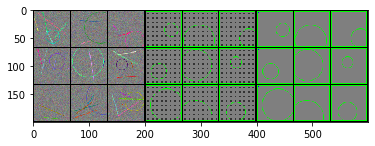

In [9]:
# load hyperparameter dictionary
params = default_params('circle')

# initialize dataset
dataset = CircleDataset(params['imagesize'], params['imagesize'])

# visualize your created dataset
visualize_circle_dsac(params, dataset)

## Task 3
(2 points)

Implement the circle loss function. The direct CNN prediction should work now. Run the code (~100 iterations) and plot the training loss.

In [23]:
class CircleLoss(ICircleLoss):
    def __call__(self, est, gt):
        '''
        Calculate the circle loss.

        est -- estimated circle, form: [cX, cY, r]
        gt -- ground truth circle, form: [cX, cY, r]
        '''
        # TODO:

        # You are given the estimated and ground truth circle (both given as 3-vectors containting 
        # the center coordinate and radius.

        # Calculate the loss as the Euclidean distance between the circle centers plus the absolute difference in radii.
        # Note that the given circle parameters are in relative coordinate, i.e. from 0 to 1. The loss should be in pixels,
        # so multiply by self.image_size
        
        # You should return one value: the loss.
        
        # -- STUDENT BEGIN --------------------------------------------------------
        est = est * self.image_size
        gt = gt * self.image_size
        loss = torch.sqrt((est[0] - gt[0])**2 + (est[1] - gt[1])**2) + (est[2] - gt[2]).abs()
#         loss = loss * self.image_size
        
        return loss

        # -- STUDENT END ----------------------------------------------------------

Iteration:      0, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 74.50, Time: 0.76s


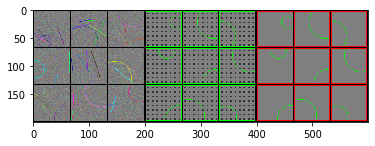

Storing snapshot. Validation loss: 0.00
Iteration:      1, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 64.95, Time: 0.85s
Iteration:      2, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 65.60, Time: 0.84s
Iteration:      3, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 54.76, Time: 1.06s
Iteration:      4, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 64.83, Time: 0.88s
Iteration:      5, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 56.99, Time: 0.93s
Iteration:      6, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 51.14, Time: 0.83s
Iteration:      7, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 49.36, Time: 0.96s
Iteration:      8, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 49.27, Time: 0.79s
Iteration:      9, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 51.92, Time: 0.85s
Iteration:     10, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

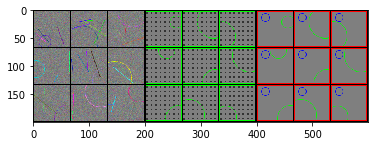

Storing snapshot. Validation loss: 0.00
Iteration:     11, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 48.85, Time: 0.84s
Iteration:     12, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 52.14, Time: 0.91s
Iteration:     13, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 49.59, Time: 0.83s
Iteration:     14, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 48.54, Time: 0.81s
Iteration:     15, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 44.51, Time: 0.76s
Iteration:     16, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 43.08, Time: 0.80s
Iteration:     17, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 48.34, Time: 0.82s
Iteration:     18, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 42.73, Time: 0.79s
Iteration:     19, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 35.29, Time: 0.80s
Iteration:     20, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

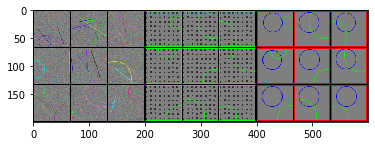

Storing snapshot. Validation loss: 0.00
Iteration:     21, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 43.30, Time: 0.88s
Iteration:     22, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 41.19, Time: 0.84s
Iteration:     23, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 44.63, Time: 0.84s
Iteration:     24, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 38.81, Time: 0.85s
Iteration:     25, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 38.15, Time: 0.84s
Iteration:     26, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 41.98, Time: 0.81s
Iteration:     27, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 41.38, Time: 0.80s
Iteration:     28, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.81, Time: 0.81s
Iteration:     29, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 40.70, Time: 0.87s
Iteration:     30, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

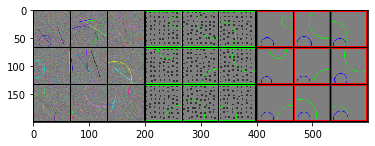

Storing snapshot. Validation loss: 0.00
Iteration:     31, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 38.85, Time: 1.02s
Iteration:     32, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 35.11, Time: 1.04s
Iteration:     33, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 35.70, Time: 1.09s
Iteration:     34, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 38.08, Time: 0.84s
Iteration:     35, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 38.60, Time: 0.84s
Iteration:     36, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.56, Time: 0.82s
Iteration:     37, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 36.07, Time: 0.79s
Iteration:     38, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 34.86, Time: 0.81s
Iteration:     39, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 37.92, Time: 0.82s
Iteration:     40, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

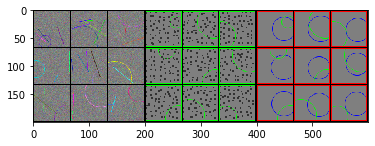

Storing snapshot. Validation loss: 0.00
Iteration:     41, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 34.89, Time: 0.75s
Iteration:     42, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 36.39, Time: 0.78s
Iteration:     43, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.98, Time: 0.86s
Iteration:     44, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.41, Time: 0.78s
Iteration:     45, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 35.50, Time: 0.83s
Iteration:     46, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 34.31, Time: 0.78s
Iteration:     47, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.90, Time: 0.75s
Iteration:     48, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.55, Time: 1.04s
Iteration:     49, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 28.70, Time: 0.85s
Iteration:     50, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

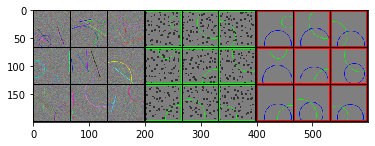

Storing snapshot. Validation loss: 0.00
Iteration:     51, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 36.76, Time: 0.82s
Iteration:     52, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 36.51, Time: 1.07s
Iteration:     53, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 36.30, Time: 0.85s
Iteration:     54, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 28.90, Time: 0.83s
Iteration:     55, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.73, Time: 0.93s
Iteration:     56, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 29.11, Time: 0.84s
Iteration:     57, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.48, Time: 0.81s
Iteration:     58, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 29.63, Time: 0.79s
Iteration:     59, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 30.81, Time: 0.75s
Iteration:     60, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

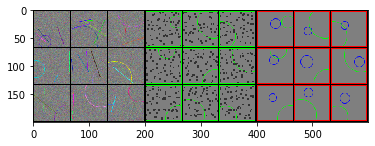

Storing snapshot. Validation loss: 0.00
Iteration:     61, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 26.40, Time: 0.80s
Iteration:     62, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 35.07, Time: 0.84s
Iteration:     63, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.03, Time: 0.86s
Iteration:     64, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.22, Time: 0.80s
Iteration:     65, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.44, Time: 0.87s
Iteration:     66, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 29.62, Time: 0.84s
Iteration:     67, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 37.64, Time: 0.91s
Iteration:     68, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.19, Time: 0.87s
Iteration:     69, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.04, Time: 0.80s
Iteration:     70, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

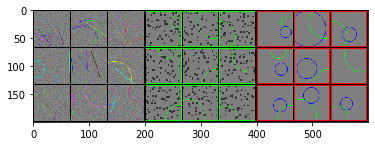

Storing snapshot. Validation loss: 0.00
Iteration:     71, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.33, Time: 0.90s
Iteration:     72, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 35.06, Time: 0.85s
Iteration:     73, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.37, Time: 1.13s
Iteration:     74, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.38, Time: 0.93s
Iteration:     75, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 37.01, Time: 1.01s
Iteration:     76, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 29.04, Time: 1.20s
Iteration:     77, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.50, Time: 1.45s
Iteration:     78, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.41, Time: 1.12s
Iteration:     79, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 28.85, Time: 1.09s
Iteration:     80, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

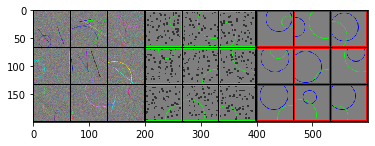

Storing snapshot. Validation loss: 0.00
Iteration:     81, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 35.92, Time: 1.98s
Iteration:     82, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 34.61, Time: 1.59s
Iteration:     83, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.32, Time: 0.95s
Iteration:     84, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 29.05, Time: 0.80s
Iteration:     85, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 26.97, Time: 0.78s
Iteration:     86, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 27.83, Time: 0.78s
Iteration:     87, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.72, Time: 0.84s
Iteration:     88, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 28.94, Time: 0.79s
Iteration:     89, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 30.45, Time: 0.86s
Iteration:     90, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

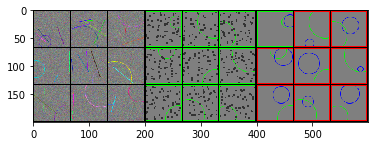

Storing snapshot. Validation loss: 0.00
Iteration:     91, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.20, Time: 0.79s
Iteration:     92, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 30.69, Time: 0.85s
Iteration:     93, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 29.96, Time: 0.78s
Iteration:     94, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 25.70, Time: 0.75s
Iteration:     95, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 27.14, Time: 0.80s
Iteration:     96, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 28.20, Time: 0.80s
Iteration:     97, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 33.66, Time: 0.80s
Iteration:     98, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 32.30, Time: 0.77s
Iteration:     99, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss: 31.27, Time: 0.82s
Iteration:    100, DSAC Expected Loss: 0.00, DSAC Top Loss: 0.00, Direct Loss:

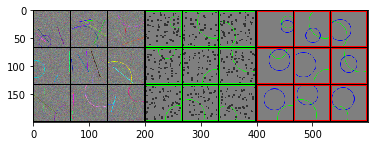

Storing snapshot. Validation loss: 0.00
Done without errors.


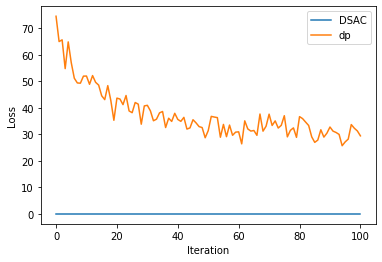

In [24]:
# load hyperparameter dictionary
params = default_params('circle')

# initialize dataset
dataset = CircleDataset(params['imagesize'], params['imagesize'])

# initialize loss function
loss = CircleLoss(params['imagesize'])

# train and plot loss
train_circle_dsac(params, dataset, loss)
plot_loss('./models/log_dsac_circle.txt')

## Task 4
(5 + 1 points)

Implement DSAC circle fitting.
1. Implement hypothesis sampling. (1 point)
-- Fill in the blank method `_sample_hyp`

2. Implement soft inlier count. (2 points)
-- Fill in the blank method `_soft_inlier_count`

3. Implement refinement with hard inliers (2 point)
-- Fill in the blank method `_refine_hyp`

4. Bonus: Implement refinement with soft inliers (+1 point)

In [25]:
class CircleDSAC(ICircleDSAC):
    def __init__(self, hyps, inlier_thresh, inlier_beta, inlier_alpha, loss_function):
        ICircleDSAC.__init__(self, hyps, inlier_thresh, inlier_beta, inlier_alpha, loss_function)
    
    def _sample_hyp(self, x, y):
        '''
        Calculate a circle hypothesis (cX, cY, r) from three random points.

        x -- vector of x values
        y -- vector of y values
        '''
        # TASK 4.1.

        # You are given all predicted points of the CNN (vector of x coordinates, and vector of y coordinates)
        # Randomly select three points (but no point twice within this call) and fit a circle 
        # (see the slides for instructions).

        # Check if the radius is below 1 (sanity check). If not, try again. Try 1000 times max.
        
        # You should return four values: x of the circle center, y of the circle center, the radius,
        # and True resp. False if no valid circle has been found within 1000 tries (radius < 1).

        # -- STUDENT BEGIN --------------------------------------------------------
        for i in range(1000):
            found = False
            idxs = torch.randint(0, x.shape[0], (3,))
            while len(torch.unique(idxs)) < 3:
                idxs = torch.randint(0, x.shape[0], (3,))

            s_x = x[idxs]
            s_y = y[idxs]
            A = torch.det(torch.tensor([[s_x[0], s_y[0], 1],
                                       [s_x[1], s_y[1], 1],
                                       [s_x[2], s_y[2], 1],]))
            B = torch.det(torch.tensor([[s_x[0]**2+s_y[0]**2, s_y[0], 1],
                                       [s_x[1]**2+s_y[1]**2, s_y[1], 1],
                                       [s_x[2]**2+s_y[2]**2, s_y[2], 1],]))
            C = torch.det(torch.tensor([[s_x[0]**2+s_y[0]**2, s_x[0], 1],
                                       [s_x[1]**2+s_y[1]**2, s_x[1], 1],
                                       [s_x[2]**2+s_y[2]**2, s_x[2], 1],]))
            D = torch.det(torch.tensor([[s_x[0]**2+s_y[0]**2, s_x[0], s_y[0]],
                                       [s_x[1]**2+s_y[1]**2, s_x[1], s_y[1]],
                                       [s_x[2]**2+s_y[2]**2, s_x[2], s_y[2]],]))

            m_x = -B / (2 * A)
            m_y = -C / (2 * A)
            r = torch.sqrt((m_x - s_x[0]) ** 2 + (m_y - s_y[2]) ** 2)

            if r < 1: continue
            found = True
            break

        # -- STUDENT END ----------------------------------------------------------
        
        return m_x, m_y, r, found
        
    def _soft_inlier_count(self, cX, cY, r, x, y):
        '''
        Soft inlier count for a given circle and a given set of points.

        cX -- x of circle center
        cY -- y of circle center
        r -- radius of the circle
        x -- vector of x values (range 0 to 1)
        y -- vector of y values (range 0 to 1)
        '''
        # TASK 4.2.

        # You are given the circle parameters cX, cY and r, as well as all predicted points of the CNN (x, y)
        # Calculate the distance of each point to the circle.
        # Turn the distances to soft inlier scores by applying a sigmoid as in the line fitting code.
        # Use the member attributes self.inlier_beta as the scaling factor within the sigmoid,
        # and self.inlier_thresh as the soft inlier threshold (see line fitting code).

        # Note that when using the sqrt() function, add an epsilon to the argument since the gradient of sqrt(0) is unstable.

        # You should return two values: a score for the circle (sum of soft inlier scores), 
        # and a vector with the soft inlier score of each point.

        # -- STUDENT BEGIN --------------------------------------------------------
        # point circle distances
        dists = torch.sqrt(((x-cX)**2 + (y-cY)**2) + 1e-10)

        # soft inliers
        dists = 1 - torch.sigmoid(self.inlier_beta * (dists - self.inlier_thresh)) 
        score = torch.sum(dists)
        
        # -- STUDENT END ----------------------------------------------------------

        return score, dists
    
    def _refine_hyp(self, x, y, weights):
        '''
        Refinement by least squares fit.

        x -- vector of x values (range 0 to 1)
        y -- vector of y values (range 0 to 1)
        weights -- vector of weights (1 per point)		
        '''
        # TASK 4.3. (and 4.4.)

        # You are given all predicted points of the CNN (x, y) and a soft inlier weight for each point (weights).
        # Do a least squares fit to all points with weight > 0.5, or a weighted least squares fit to all points.
        # A description can be found in materials/circle_fit.pdf

        # Note that PyTorch offers a differentiable inverse() function. 

        # You should return three values: x of the circle center, y of the circle center, and the radius

        # -- STUDENT BEGIN --------------------------------------------------------
        x_bar = x.mean()
        y_bar = y.mean()
        u = x - x_bar
        v = y - y_bar
        S_uu = (u**2).sum()
        S_vv = (v**2).sum()
        S_uv = (u*v).sum()
        S_uuu = (u**3).sum()
        S_vvv = (v**3).sum()
        S_vuu = (v*u**2).sum()
        S_uvv = (u*v**2).sum()
        
        t1 = (S_uuu + S_uvv) / 2
        t2 = (S_vvv + S_vuu) / 2
        
        u_c = (t1 - S_uv * t2 / S_vv) / (S_uu - S_uv**2 / S_vv)
        v_c = (t2 - S_uv * u_c) / S_vv
        
        x_c = u_c + x_bar
        y_c = v_c + y_bar
        
        alpha = u_c**2 + v_c**2 + (S_uu + S_vv) / len(x)
        r_c = torch.sqrt(alpha)
        
        # -- STUDENT END ----------------------------------------------------------

        return x_c, y_c, r_c

Iteration:      0, DSAC Expected Loss: 34.37, DSAC Top Loss: 28.43, Direct Loss: 86.08, Time: 6.51s


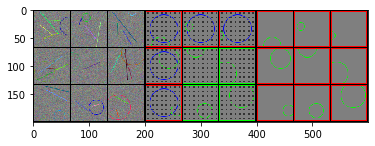

Storing snapshot. Validation loss: 22.32
Iteration:      1, DSAC Expected Loss: 30.08, DSAC Top Loss: 0.00, Direct Loss: 75.46, Time: 7.32s
Iteration:      2, DSAC Expected Loss: 33.38, DSAC Top Loss: 1.49, Direct Loss: 61.30, Time: 6.90s
Iteration:      3, DSAC Expected Loss: 28.79, DSAC Top Loss: 15.97, Direct Loss: 59.56, Time: 6.97s
Iteration:      4, DSAC Expected Loss: 29.05, DSAC Top Loss: 6.27, Direct Loss: 53.70, Time: 7.03s
Iteration:      5, DSAC Expected Loss: 31.84, DSAC Top Loss: 3.54, Direct Loss: 53.66, Time: 6.90s
Iteration:      6, DSAC Expected Loss: 29.67, DSAC Top Loss: 2.48, Direct Loss: 54.16, Time: 6.91s
Iteration:      7, DSAC Expected Loss: 30.35, DSAC Top Loss: 2.48, Direct Loss: 56.18, Time: 6.91s
Iteration:      8, DSAC Expected Loss: 31.04, DSAC Top Loss: 2.79, Direct Loss: 56.76, Time: 6.44s
Iteration:      9, DSAC Expected Loss: 29.79, DSAC Top Loss: 3.21, Direct Loss: 45.57, Time: 6.56s
Iteration:     10, DSAC Expected Loss: 30.65, DSAC Top Loss: 0.89, 

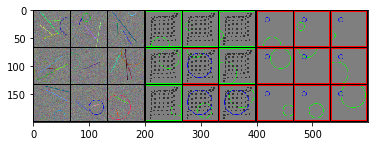

Storing snapshot. Validation loss: 8.75
Iteration:     11, DSAC Expected Loss: 31.01, DSAC Top Loss: 1.15, Direct Loss: 52.40, Time: 6.52s
Iteration:     12, DSAC Expected Loss: 32.43, DSAC Top Loss: 0.00, Direct Loss: 41.93, Time: 6.53s
Iteration:     13, DSAC Expected Loss: 34.97, DSAC Top Loss: 3.97, Direct Loss: 48.91, Time: 6.60s
Iteration:     14, DSAC Expected Loss: 28.85, DSAC Top Loss: 3.81, Direct Loss: 46.12, Time: 6.69s
Iteration:     15, DSAC Expected Loss: 28.12, DSAC Top Loss: 10.85, Direct Loss: 48.19, Time: 6.91s
Iteration:     16, DSAC Expected Loss: 25.63, DSAC Top Loss: 6.35, Direct Loss: 44.82, Time: 7.18s
Iteration:     17, DSAC Expected Loss: 28.98, DSAC Top Loss: 6.16, Direct Loss: 46.15, Time: 6.97s
Iteration:     18, DSAC Expected Loss: 31.69, DSAC Top Loss: 7.92, Direct Loss: 43.85, Time: 7.18s
Iteration:     19, DSAC Expected Loss: 27.55, DSAC Top Loss: 8.52, Direct Loss: 40.83, Time: 7.19s
Iteration:     20, DSAC Expected Loss: 29.30, DSAC Top Loss: 5.14, D

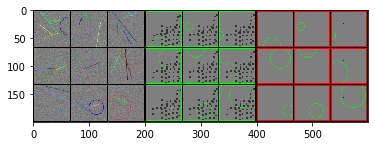

Storing snapshot. Validation loss: 0.00
Iteration:     21, DSAC Expected Loss: 26.05, DSAC Top Loss: 3.28, Direct Loss: 39.15, Time: 6.36s
Iteration:     22, DSAC Expected Loss: 29.29, DSAC Top Loss: 5.57, Direct Loss: 36.86, Time: 6.45s
Iteration:     23, DSAC Expected Loss: 32.55, DSAC Top Loss: 6.86, Direct Loss: 37.90, Time: 6.43s
Iteration:     24, DSAC Expected Loss: 29.81, DSAC Top Loss: 7.54, Direct Loss: 37.62, Time: 6.29s
Iteration:     25, DSAC Expected Loss: 28.48, DSAC Top Loss: 3.05, Direct Loss: 40.40, Time: 6.68s
Iteration:     26, DSAC Expected Loss: 29.30, DSAC Top Loss: 8.41, Direct Loss: 40.41, Time: 6.24s
Iteration:     27, DSAC Expected Loss: 26.30, DSAC Top Loss: 7.13, Direct Loss: 32.74, Time: 6.41s
Iteration:     28, DSAC Expected Loss: 25.89, DSAC Top Loss: 4.75, Direct Loss: 36.42, Time: 6.09s
Iteration:     29, DSAC Expected Loss: 26.53, DSAC Top Loss: 5.66, Direct Loss: 38.44, Time: 6.14s
Iteration:     30, DSAC Expected Loss: 25.77, DSAC Top Loss: 11.04, D

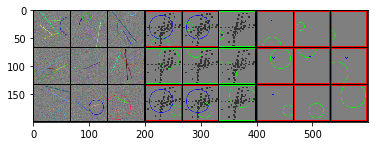

Storing snapshot. Validation loss: 15.72
Iteration:     31, DSAC Expected Loss: 26.72, DSAC Top Loss: 5.79, Direct Loss: 34.30, Time: 6.07s
Iteration:     32, DSAC Expected Loss: 29.48, DSAC Top Loss: 4.57, Direct Loss: 37.36, Time: 6.20s
Iteration:     33, DSAC Expected Loss: 28.99, DSAC Top Loss: 5.63, Direct Loss: 39.04, Time: 5.99s
Iteration:     34, DSAC Expected Loss: 28.03, DSAC Top Loss: 0.00, Direct Loss: 37.88, Time: 6.13s
Iteration:     35, DSAC Expected Loss: 23.12, DSAC Top Loss: 1.61, Direct Loss: 31.79, Time: 5.99s
Iteration:     36, DSAC Expected Loss: 27.39, DSAC Top Loss: 0.00, Direct Loss: 35.35, Time: 6.05s
Iteration:     37, DSAC Expected Loss: 26.54, DSAC Top Loss: 0.00, Direct Loss: 32.03, Time: 6.34s
Iteration:     38, DSAC Expected Loss: 27.16, DSAC Top Loss: 1.24, Direct Loss: 33.86, Time: 6.50s
Iteration:     39, DSAC Expected Loss: 27.02, DSAC Top Loss: 3.26, Direct Loss: 34.04, Time: 6.36s
Iteration:     40, DSAC Expected Loss: 32.28, DSAC Top Loss: 4.44, D

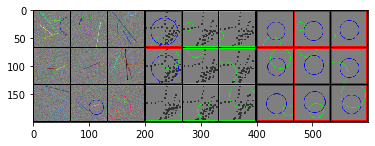

Storing snapshot. Validation loss: 6.91
Iteration:     41, DSAC Expected Loss: 29.89, DSAC Top Loss: 3.87, Direct Loss: 32.52, Time: 6.52s
Iteration:     42, DSAC Expected Loss: 29.32, DSAC Top Loss: 7.79, Direct Loss: 35.58, Time: 6.43s
Iteration:     43, DSAC Expected Loss: 27.89, DSAC Top Loss: 7.90, Direct Loss: 30.12, Time: 6.69s
Iteration:     44, DSAC Expected Loss: 30.82, DSAC Top Loss: 7.75, Direct Loss: 30.94, Time: 6.40s
Iteration:     45, DSAC Expected Loss: 29.23, DSAC Top Loss: 9.51, Direct Loss: 38.18, Time: 6.33s
Iteration:     46, DSAC Expected Loss: 29.02, DSAC Top Loss: 12.11, Direct Loss: 33.24, Time: 6.50s
Iteration:     47, DSAC Expected Loss: 29.10, DSAC Top Loss: 8.43, Direct Loss: 35.32, Time: 6.52s
Iteration:     48, DSAC Expected Loss: 27.87, DSAC Top Loss: 8.57, Direct Loss: 30.93, Time: 6.43s
Iteration:     49, DSAC Expected Loss: 24.49, DSAC Top Loss: 12.52, Direct Loss: 32.11, Time: 6.57s
Iteration:     50, DSAC Expected Loss: 28.09, DSAC Top Loss: 7.35, 

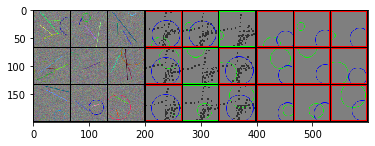

Storing snapshot. Validation loss: 22.65
Iteration:     51, DSAC Expected Loss: 25.48, DSAC Top Loss: 6.82, Direct Loss: 30.26, Time: 6.53s
Iteration:     52, DSAC Expected Loss: 25.52, DSAC Top Loss: 9.55, Direct Loss: 29.97, Time: 6.39s
Iteration:     53, DSAC Expected Loss: 27.68, DSAC Top Loss: 12.16, Direct Loss: 32.81, Time: 6.48s
Iteration:     54, DSAC Expected Loss: 30.68, DSAC Top Loss: 7.46, Direct Loss: 34.84, Time: 6.68s
Iteration:     55, DSAC Expected Loss: 26.83, DSAC Top Loss: 6.73, Direct Loss: 28.45, Time: 6.71s
Iteration:     56, DSAC Expected Loss: 29.43, DSAC Top Loss: 5.24, Direct Loss: 34.27, Time: 6.84s
Iteration:     57, DSAC Expected Loss: 27.19, DSAC Top Loss: 2.08, Direct Loss: 31.91, Time: 6.77s
Iteration:     58, DSAC Expected Loss: 29.68, DSAC Top Loss: 9.18, Direct Loss: 39.26, Time: 6.50s
Iteration:     59, DSAC Expected Loss: 28.45, DSAC Top Loss: 2.83, Direct Loss: 31.43, Time: 6.59s
Iteration:     60, DSAC Expected Loss: 28.51, DSAC Top Loss: 2.35, 

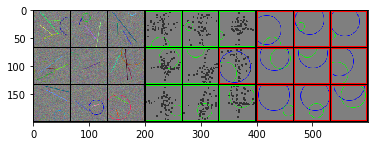

Storing snapshot. Validation loss: 3.22
Iteration:     61, DSAC Expected Loss: 26.79, DSAC Top Loss: 8.34, Direct Loss: 32.06, Time: 6.82s
Iteration:     62, DSAC Expected Loss: 30.22, DSAC Top Loss: 15.68, Direct Loss: 31.49, Time: 6.54s
Iteration:     63, DSAC Expected Loss: 24.05, DSAC Top Loss: 11.42, Direct Loss: 30.37, Time: 6.72s
Iteration:     64, DSAC Expected Loss: 27.40, DSAC Top Loss: 7.95, Direct Loss: 33.16, Time: 6.77s
Iteration:     65, DSAC Expected Loss: 26.18, DSAC Top Loss: 8.32, Direct Loss: 32.28, Time: 6.56s
Iteration:     66, DSAC Expected Loss: 29.87, DSAC Top Loss: 8.37, Direct Loss: 33.46, Time: 6.60s
Iteration:     67, DSAC Expected Loss: 27.73, DSAC Top Loss: 9.33, Direct Loss: 31.00, Time: 6.67s
Iteration:     68, DSAC Expected Loss: 24.50, DSAC Top Loss: 3.64, Direct Loss: 30.28, Time: 6.90s
Iteration:     69, DSAC Expected Loss: 26.24, DSAC Top Loss: 4.90, Direct Loss: 26.39, Time: 6.54s
Iteration:     70, DSAC Expected Loss: 24.95, DSAC Top Loss: 2.28, 

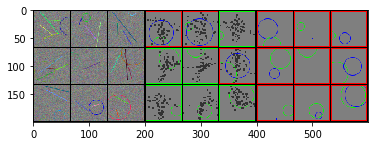

Storing snapshot. Validation loss: 10.83
Iteration:     71, DSAC Expected Loss: 29.39, DSAC Top Loss: 6.80, Direct Loss: 32.34, Time: 6.59s
Iteration:     72, DSAC Expected Loss: 30.31, DSAC Top Loss: 5.70, Direct Loss: 34.87, Time: 6.50s
Iteration:     73, DSAC Expected Loss: 25.26, DSAC Top Loss: 7.32, Direct Loss: 27.49, Time: 6.56s
Iteration:     74, DSAC Expected Loss: 27.19, DSAC Top Loss: 2.08, Direct Loss: 28.75, Time: 6.49s
Iteration:     75, DSAC Expected Loss: 30.54, DSAC Top Loss: 3.24, Direct Loss: 31.00, Time: 6.57s
Iteration:     76, DSAC Expected Loss: 23.49, DSAC Top Loss: 2.20, Direct Loss: 24.82, Time: 6.74s
Iteration:     77, DSAC Expected Loss: 25.55, DSAC Top Loss: 0.87, Direct Loss: 30.99, Time: 6.90s
Iteration:     78, DSAC Expected Loss: 27.48, DSAC Top Loss: 6.49, Direct Loss: 31.63, Time: 6.95s
Iteration:     79, DSAC Expected Loss: 26.58, DSAC Top Loss: 5.73, Direct Loss: 30.53, Time: 6.76s
Iteration:     80, DSAC Expected Loss: 24.79, DSAC Top Loss: 7.62, D

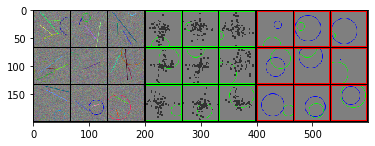

Storing snapshot. Validation loss: 0.00
Iteration:     81, DSAC Expected Loss: 30.55, DSAC Top Loss: 7.39, Direct Loss: 33.42, Time: 6.63s
Iteration:     82, DSAC Expected Loss: 27.25, DSAC Top Loss: 3.70, Direct Loss: 33.94, Time: 7.15s
Iteration:     83, DSAC Expected Loss: 26.47, DSAC Top Loss: 1.70, Direct Loss: 29.96, Time: 7.57s
Iteration:     84, DSAC Expected Loss: 28.64, DSAC Top Loss: 5.26, Direct Loss: 27.87, Time: 6.65s
Iteration:     85, DSAC Expected Loss: 26.82, DSAC Top Loss: 5.38, Direct Loss: 31.40, Time: 6.72s
Iteration:     86, DSAC Expected Loss: 22.44, DSAC Top Loss: 2.11, Direct Loss: 27.08, Time: 7.04s
Iteration:     87, DSAC Expected Loss: 24.42, DSAC Top Loss: 4.62, Direct Loss: 29.95, Time: 6.58s
Iteration:     88, DSAC Expected Loss: 29.01, DSAC Top Loss: 4.22, Direct Loss: 29.13, Time: 6.92s
Iteration:     89, DSAC Expected Loss: 30.13, DSAC Top Loss: 7.82, Direct Loss: 34.85, Time: 6.95s
Iteration:     90, DSAC Expected Loss: 27.77, DSAC Top Loss: 9.96, Di

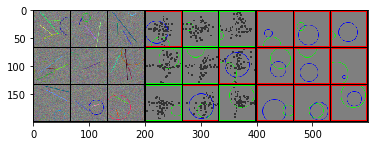

Storing snapshot. Validation loss: 8.54
Iteration:     91, DSAC Expected Loss: 26.53, DSAC Top Loss: 12.41, Direct Loss: 33.63, Time: 7.18s
Iteration:     92, DSAC Expected Loss: 29.72, DSAC Top Loss: 18.86, Direct Loss: 33.24, Time: 7.06s
Iteration:     93, DSAC Expected Loss: 31.73, DSAC Top Loss: 13.65, Direct Loss: 31.08, Time: 8.02s
Iteration:     94, DSAC Expected Loss: 28.01, DSAC Top Loss: 9.01, Direct Loss: 32.07, Time: 7.42s
Iteration:     95, DSAC Expected Loss: 24.68, DSAC Top Loss: 8.91, Direct Loss: 31.18, Time: 6.42s
Iteration:     96, DSAC Expected Loss: 23.78, DSAC Top Loss: 8.44, Direct Loss: 30.64, Time: 8.71s
Iteration:     97, DSAC Expected Loss: 28.67, DSAC Top Loss: 2.77, Direct Loss: 28.26, Time: 8.97s
Iteration:     98, DSAC Expected Loss: 26.74, DSAC Top Loss: 5.82, Direct Loss: 26.46, Time: 7.30s
Iteration:     99, DSAC Expected Loss: 26.96, DSAC Top Loss: 5.99, Direct Loss: 30.49, Time: 6.90s
Iteration:    100, DSAC Expected Loss: 28.31, DSAC Top Loss: 6.89,

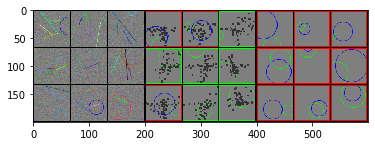

Storing snapshot. Validation loss: 9.91
Done without errors.


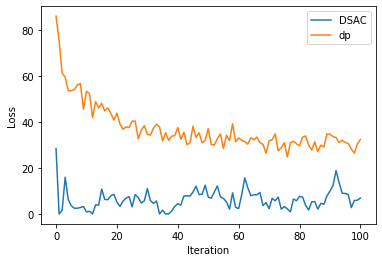

In [26]:
# load hyperparameter dictionary
params = default_params('circle')

# initialize dataset
dataset = CircleDataset(params['imagesize'], params['imagesize'])

# initialize loss function
loss = CircleLoss(params['imagesize'])

# initialize DSAC
dsac = CircleDSAC(params['hypotheses'], params['inlierthreshold'], params['inlierbeta'], params['inlieralpha'], loss)

# train and plot losses
train_circle_dsac(params, dataset, loss, dsac)
plot_loss('./models/log_dsac_circle.txt')

## Task 5
(priceless)

Run everything, plot losses, play with parameters, look at images

In [30]:
# load default parameters
params = default_params('circle')

# TODO: play around with parameter dictionary
params = {
    'receptivefield': 65,
    'capacity': 4,
    'hypotheses': 30,
    'inlierthreshold': 0.03,
    'inlieralpha': 0.3,
    'inlierbeta': 80.0,
    'learningrate': 0.006,
    'lrstep': 2500,
    'lrstepoffset': 30000,
    'batchsize': 32,
    'trainiterations': 50,
    'imagesize': 64,
    'storeinterval': 10,
    'valsize': 9,
    'valthresh': 2,
    'use_gpu': False,
    'id': 'id'
}

# initialize dataset
dataset = CircleDataset(params['imagesize'], params['imagesize'])

# initialize loss function
loss = CircleLoss(params['imagesize'])

# initialize DSAC
dsac = CircleDSAC(params['hypotheses'], params['inlierthreshold'], params['inlierbeta'], params['inlieralpha'], loss)

In [31]:
print(params)

{'receptivefield': 65, 'capacity': 4, 'hypotheses': 30, 'inlierthreshold': 0.03, 'inlieralpha': 0.3, 'inlierbeta': 80.0, 'learningrate': 0.006, 'lrstep': 2500, 'lrstepoffset': 30000, 'batchsize': 32, 'trainiterations': 50, 'imagesize': 64, 'storeinterval': 10, 'valsize': 9, 'valthresh': 2, 'use_gpu': False, 'id': 'id'}


Iteration:      0, DSAC Expected Loss: 32.89, DSAC Top Loss: 13.65, Direct Loss: 108.21, Time: 3.65s


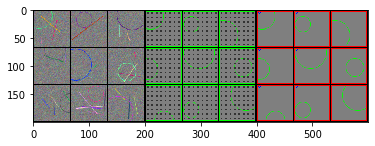

Storing snapshot. Validation loss: 0.00
Iteration:      1, DSAC Expected Loss: 36.75, DSAC Top Loss: 5.51, Direct Loss: 54.86, Time: 3.38s
Iteration:      2, DSAC Expected Loss: 31.94, DSAC Top Loss: 20.82, Direct Loss: 91.84, Time: 3.79s
Iteration:      3, DSAC Expected Loss: 31.23, DSAC Top Loss: 0.62, Direct Loss: 103.97, Time: 3.58s
Iteration:      4, DSAC Expected Loss: 33.46, DSAC Top Loss: 6.55, Direct Loss: 71.60, Time: 3.98s
Iteration:      5, DSAC Expected Loss: 31.58, DSAC Top Loss: 2.05, Direct Loss: 61.91, Time: 3.97s
Iteration:      6, DSAC Expected Loss: 33.83, DSAC Top Loss: 5.40, Direct Loss: 47.15, Time: 3.92s
Iteration:      7, DSAC Expected Loss: 32.35, DSAC Top Loss: 5.58, Direct Loss: 45.95, Time: 3.83s
Iteration:      8, DSAC Expected Loss: 32.51, DSAC Top Loss: 5.39, Direct Loss: 42.94, Time: 3.91s
Iteration:      9, DSAC Expected Loss: 31.66, DSAC Top Loss: 3.65, Direct Loss: 44.01, Time: 3.91s
Iteration:     10, DSAC Expected Loss: 32.31, DSAC Top Loss: 10.94,

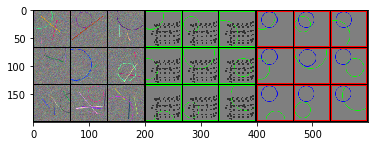

Storing snapshot. Validation loss: 0.00
Iteration:     11, DSAC Expected Loss: 32.42, DSAC Top Loss: 4.60, Direct Loss: 40.50, Time: 4.01s
Iteration:     12, DSAC Expected Loss: 35.53, DSAC Top Loss: 4.37, Direct Loss: 40.28, Time: 3.72s
Iteration:     13, DSAC Expected Loss: 30.01, DSAC Top Loss: 0.81, Direct Loss: 33.36, Time: 3.98s
Iteration:     14, DSAC Expected Loss: 35.58, DSAC Top Loss: 1.11, Direct Loss: 35.67, Time: 4.01s
Iteration:     15, DSAC Expected Loss: 32.57, DSAC Top Loss: 0.00, Direct Loss: 35.57, Time: 4.32s
Iteration:     16, DSAC Expected Loss: 29.60, DSAC Top Loss: 0.00, Direct Loss: 37.00, Time: 3.64s
Iteration:     17, DSAC Expected Loss: 30.74, DSAC Top Loss: 0.00, Direct Loss: 34.65, Time: 3.54s
Iteration:     18, DSAC Expected Loss: 32.09, DSAC Top Loss: 2.98, Direct Loss: 34.02, Time: 3.47s
Iteration:     19, DSAC Expected Loss: 31.77, DSAC Top Loss: 2.35, Direct Loss: 33.95, Time: 3.68s
Iteration:     20, DSAC Expected Loss: 29.81, DSAC Top Loss: 0.00, Di

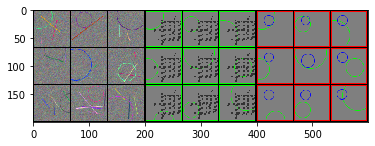

Storing snapshot. Validation loss: 0.00
Iteration:     21, DSAC Expected Loss: 32.43, DSAC Top Loss: 0.00, Direct Loss: 42.05, Time: 3.58s
Iteration:     22, DSAC Expected Loss: 32.13, DSAC Top Loss: 1.63, Direct Loss: 36.01, Time: 3.74s
Iteration:     23, DSAC Expected Loss: 27.89, DSAC Top Loss: 1.04, Direct Loss: 32.55, Time: 3.64s
Iteration:     24, DSAC Expected Loss: 30.69, DSAC Top Loss: 1.40, Direct Loss: 32.00, Time: 3.83s
Iteration:     25, DSAC Expected Loss: 28.41, DSAC Top Loss: 0.83, Direct Loss: 31.03, Time: 3.79s
Iteration:     26, DSAC Expected Loss: 31.52, DSAC Top Loss: 6.93, Direct Loss: 41.72, Time: 3.89s
Iteration:     27, DSAC Expected Loss: 29.25, DSAC Top Loss: 9.62, Direct Loss: 32.36, Time: 3.79s
Iteration:     28, DSAC Expected Loss: 30.42, DSAC Top Loss: 9.13, Direct Loss: 37.17, Time: 3.88s
Iteration:     29, DSAC Expected Loss: 30.83, DSAC Top Loss: 4.68, Direct Loss: 39.63, Time: 3.86s
Iteration:     30, DSAC Expected Loss: 30.85, DSAC Top Loss: 3.07, Di

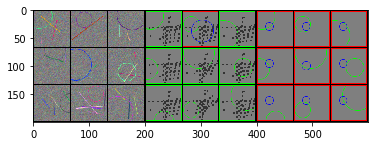

Storing snapshot. Validation loss: 3.42
Iteration:     31, DSAC Expected Loss: 29.18, DSAC Top Loss: 1.22, Direct Loss: 28.85, Time: 3.70s
Iteration:     32, DSAC Expected Loss: 29.87, DSAC Top Loss: 2.45, Direct Loss: 36.17, Time: 3.70s
Iteration:     33, DSAC Expected Loss: 29.56, DSAC Top Loss: 3.51, Direct Loss: 37.82, Time: 3.62s
Iteration:     34, DSAC Expected Loss: 29.70, DSAC Top Loss: 3.00, Direct Loss: 39.36, Time: 3.56s
Iteration:     35, DSAC Expected Loss: 28.95, DSAC Top Loss: 2.00, Direct Loss: 35.16, Time: 3.66s
Iteration:     36, DSAC Expected Loss: 29.47, DSAC Top Loss: 2.20, Direct Loss: 35.75, Time: 3.63s
Iteration:     37, DSAC Expected Loss: 29.50, DSAC Top Loss: 4.58, Direct Loss: 31.71, Time: 3.58s
Iteration:     38, DSAC Expected Loss: 32.88, DSAC Top Loss: 1.20, Direct Loss: 34.40, Time: 3.67s
Iteration:     39, DSAC Expected Loss: 32.84, DSAC Top Loss: 5.91, Direct Loss: 34.57, Time: 3.74s
Iteration:     40, DSAC Expected Loss: 30.65, DSAC Top Loss: 4.39, Di

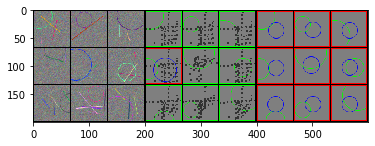

Storing snapshot. Validation loss: 3.91
Iteration:     41, DSAC Expected Loss: 32.05, DSAC Top Loss: 1.37, Direct Loss: 39.43, Time: 3.87s
Iteration:     42, DSAC Expected Loss: 29.02, DSAC Top Loss: 2.46, Direct Loss: 33.28, Time: 3.93s
Iteration:     43, DSAC Expected Loss: 29.48, DSAC Top Loss: 3.52, Direct Loss: 32.17, Time: 3.88s
Iteration:     44, DSAC Expected Loss: 26.98, DSAC Top Loss: 0.00, Direct Loss: 33.61, Time: 3.83s
Iteration:     45, DSAC Expected Loss: 28.67, DSAC Top Loss: 0.77, Direct Loss: 41.02, Time: 3.90s
Iteration:     46, DSAC Expected Loss: 26.77, DSAC Top Loss: 0.71, Direct Loss: 35.00, Time: 3.84s
Iteration:     47, DSAC Expected Loss: 32.66, DSAC Top Loss: 0.84, Direct Loss: 39.82, Time: 3.80s
Iteration:     48, DSAC Expected Loss: 31.62, DSAC Top Loss: 1.43, Direct Loss: 33.00, Time: 3.80s
Iteration:     49, DSAC Expected Loss: 29.44, DSAC Top Loss: 2.29, Direct Loss: 32.30, Time: 3.68s
Iteration:     50, DSAC Expected Loss: 29.65, DSAC Top Loss: 0.00, Di

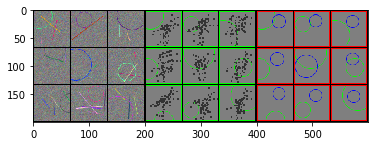

Storing snapshot. Validation loss: 0.00
Done without errors.


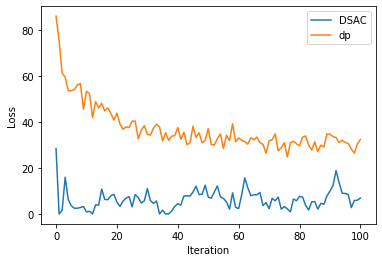

In [32]:
# train and plot losses
train_circle_dsac(params, dataset, loss, dsac)
plot_loss('./models/log_dsac_circle.txt')

## Bonus Task
(incredible fame)

DSAC and direct prediction perform similarly well in this setup. Try to adapt the synthetic image generation to cater to the advantages of either method, i.e. make the task easier or more difficult in certain ways.